# Table of Contents
 <p><div class="lev1"><a href="#helper-1">helper</a></div><div class="lev1"><a href="#lmfit-lorentzian-amplitude-2">lmfit lorentzian amplitude</a></div><div class="lev2"><a href="#function-to-fit-using-lmfit-2.1">function to fit using lmfit</a></div><div class="lev2"><a href="#bob-2.2">bob</a></div><div class="lev1"><a href="#loop-over-all-cases-3">loop over all cases</a></div><div class="lev2"><a href="#frequency-fitting-using-lmfit-3.1">frequency fitting using lmfit</a></div><div class="lev1"><a href="#construct-full-model-4">construct full model</a></div><div class="lev1"><a href="#parameter-space-fits-5">parameter space fits</a></div><div class="lev1"><a href="#Mark-1-model-class-6">Mark 1 model class</a></div><div class="lev2"><a href="#extrapolating-6.1">extrapolating</a></div><div class="lev2"><a href="#integrate-psi4-to-get-strain-and-compare-6.2">integrate psi4 to get strain and compare</a></div>

In [451]:
# env source /Users/sebastian/Desktop/work/git/stk/ml/waveforms/venv-wf/bin/activate

In [1]:
import sys
sys.path.append("../../nonspin/")

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from waveform import SingleModeNRWaveform

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [2]:
matplotlib.rcParams.update({'font.size': 18})

# helper

In [3]:

def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [4]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.3f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        

# load nr data

In [7]:
import glob
import os

In [ ]:
# 

In [97]:
key_sxs_name_to_mass_ratio = {
    "q1":"0180",
    "q2":"0169",
    "q4":"0167",
    "q5":"0107",
    "q10":"0303",
}

In [98]:
# key_sxs_name_to_mass_ratio = {
#     "q1":"0218",
#     "q2":"0169",
#     "q4":"0167",
#     "q5":"0107",
#     "q10":"0303",
# }

In [99]:
data_path = '/Users/sebastian/Desktop/work/data/'

In [100]:
nr_data_paths = {}
for k in key_sxs_name_to_mass_ratio:
    v = glob.glob( os.path.join(data_path, "SXS*{}*".format(key_sxs_name_to_mass_ratio[k])) )
    nr_data_paths.update({k:v})

In [101]:
nr_data_paths['q10']

['/Users/sebastian/Desktop/work/data/SXS_BBH_0303_Res3.h5',
 '/Users/sebastian/Desktop/work/data/SXS_BBH_0303_Res4.h5',
 '/Users/sebastian/Desktop/work/data/SXS_BBH_0303_Res5.h5']

In [162]:
ell = 2
mm = 2
npts_time = 1000*2
t1=-600
t2=80

psi4s = {}
for k in nr_data_paths.keys():
    psi4s.update({k:{}})
    for p in nr_data_paths[k]:
        p_key = p.split("/")[-1].split(".h5")[0].split("BBH_")[-1]
        p4 = Psi4(p, ell, mm, npts_time,t1=t1,t2=t2)
        psi4s[k].update({p_key:p4})

In [163]:
psi4s.keys()

['q1', 'q2', 'q5', 'q4', 'q10']

In [164]:
psi4s['q1'].keys()

['0180_Res3', '0180_Res2', '0180_Res4']

(-50, 100)

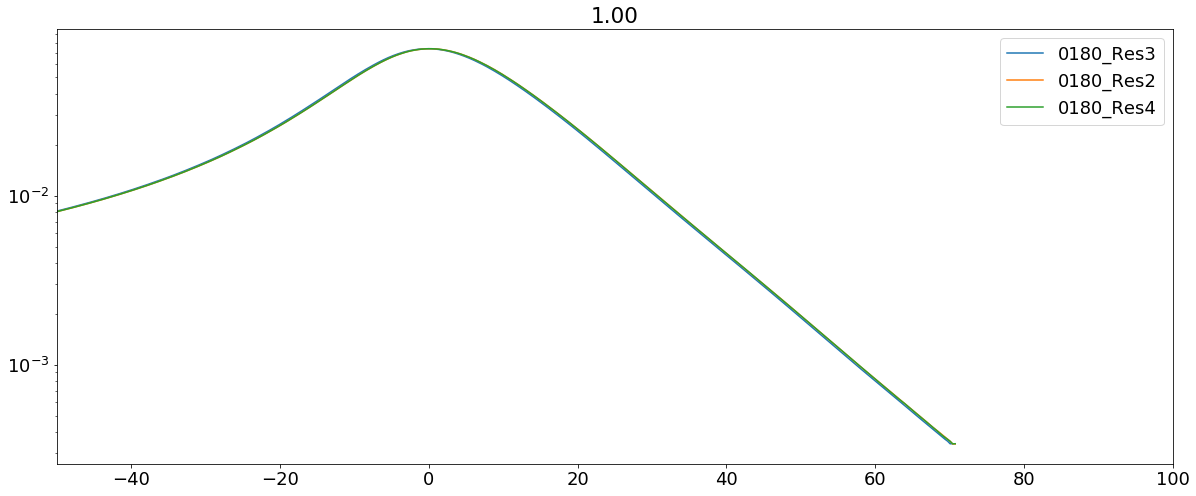

In [165]:
case = 'q1'
psi4 = psi4s[case]
plt.figure(figsize=(20,8))
for k in psi4.keys():
    plt.plot(psi4[k].times, psi4[k].psi4lm_amp, label=k)
plt.legend()
plt.title("{:.2f}".format(psi4[k].nrdata.q))
plt.yscale('log')
plt.xlim(-50, 100)

(-50, 100)

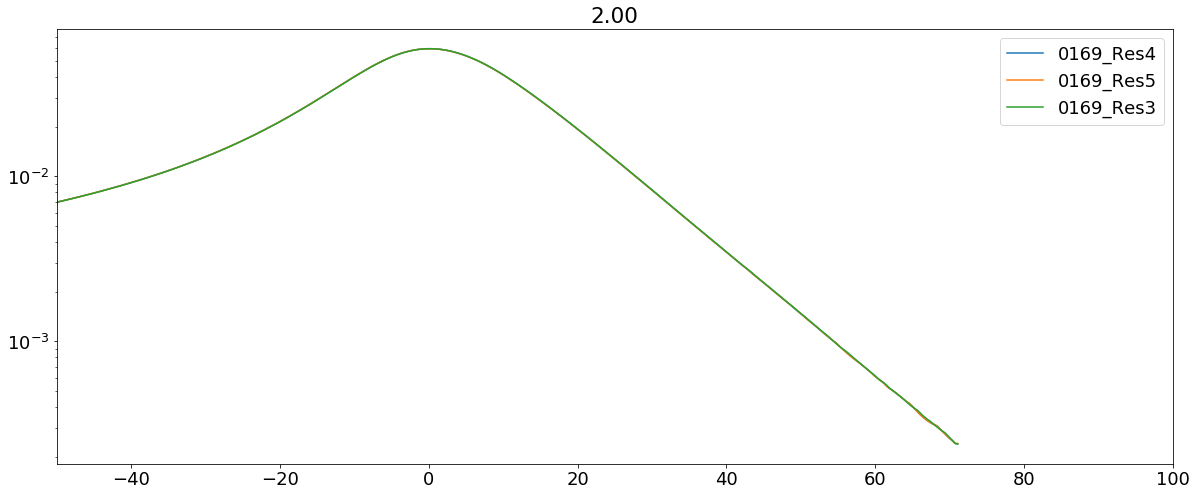

In [166]:
case = 'q2'
psi4 = psi4s[case]
plt.figure(figsize=(20,8))
for k in psi4.keys():
    plt.plot(psi4[k].times, psi4[k].psi4lm_amp, label=k)
plt.legend()
plt.title("{:.2f}".format(psi4[k].nrdata.q))
plt.yscale('log')
plt.xlim(-50, 100)

(-50, 100)

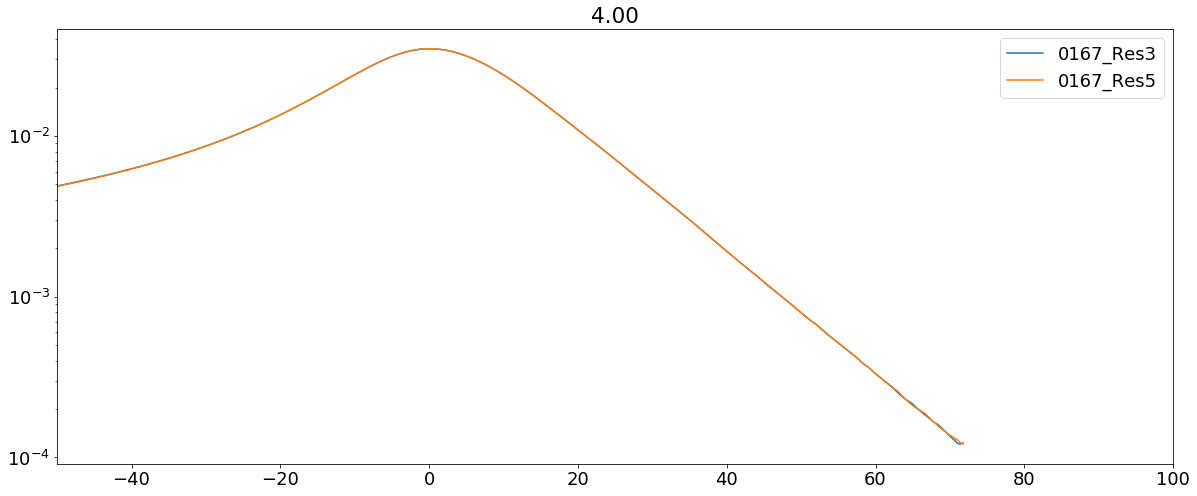

In [167]:
case = 'q4'
psi4 = psi4s[case]
plt.figure(figsize=(20,8))
for k in psi4.keys():
    plt.plot(psi4[k].times, psi4[k].psi4lm_amp, label=k)
plt.legend()
plt.title("{:.2f}".format(psi4[k].nrdata.q))
plt.yscale('log')
plt.xlim(-50, 100)

(-50, 100)

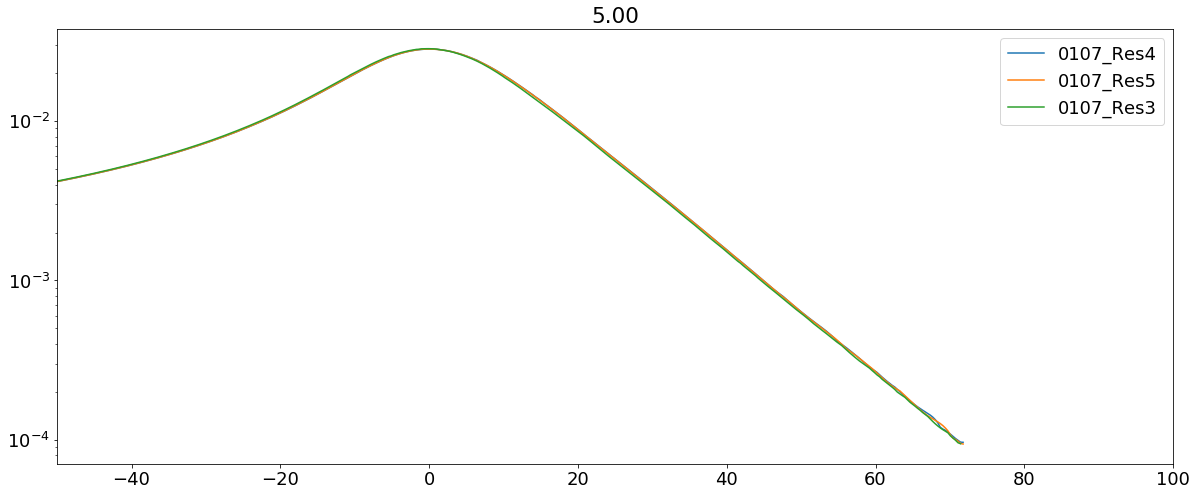

In [168]:
case = 'q5'
psi4 = psi4s[case]
plt.figure(figsize=(20,8))
for k in psi4.keys():
    plt.plot(psi4[k].times, psi4[k].psi4lm_amp, label=k)
plt.legend()
plt.title("{:.2f}".format(psi4[k].nrdata.q))
plt.yscale('log')
plt.xlim(-50, 100)

(-50, 100)

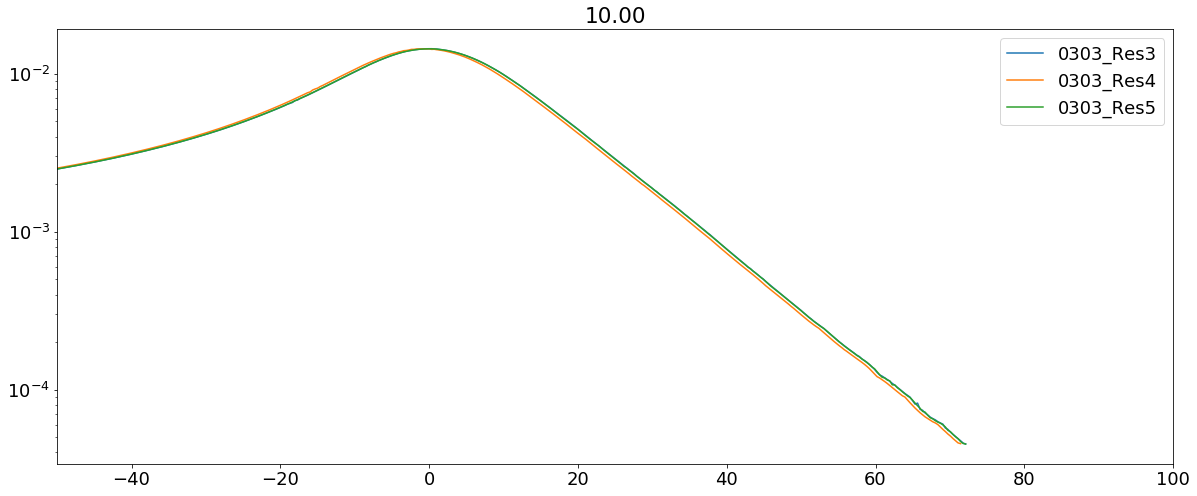

In [169]:
case = 'q10'
psi4 = psi4s[case]
plt.figure(figsize=(20,8))
for k in psi4.keys():
    plt.plot(psi4[k].times, psi4[k].psi4lm_amp, label=k)
plt.legend()
plt.title("{:.2f}".format(psi4[k].nrdata.q))
plt.yscale('log')
plt.xlim(-50, 100)